# Investigate Building Sources

Benchmark the building retrieval pipeline using bounding boxes sourced from `event_weights_grid.shp`. Results are written to a GeoParquet along with per-query timing logs.

In [13]:
from pathlib import Path
import sys
import time

import geopandas as gpd
from shapely.geometry import box
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output


REPO_ROOT = Path.cwd().resolve().parents[1]
MODULE_ROOT = REPO_ROOT / 'code' / 'overture_analysis'
if str(MODULE_ROOT) not in sys.path:
    sys.path.append(str(MODULE_ROOT))

from functions.building_retriever import BuildingRetriever

DATA_DIR = REPO_ROOT / 'data'
RESULTS_DIR = DATA_DIR / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

BUILDINGS_PATH = REPO_ROOT / 'gis_data' / 'overturemaps-us-west-2' / 'release' / '2025-08-20.1' / 'theme=buildings' / 'type=building'
SHAPEFILE_PATH = DATA_DIR / 'OSM Projects' / 'Data' / 'Large-scale events' / 'event_weights_grid.shp'

print(f'Using buildings data from: {BUILDINGS_PATH}')
print(f'Reading shapefile: {SHAPEFILE_PATH}')


Using buildings data from: /workspace/gis_data/overturemaps-us-west-2/release/2025-08-20.1/theme=buildings/type=building
Reading shapefile: /workspace/data/OSM Projects/Data/Large-scale events/event_weights_grid.shp


In [14]:
retriever = BuildingRetriever(BUILDINGS_PATH)

grid_gdf = gpd.read_file(SHAPEFILE_PATH)
if grid_gdf.empty:
    raise RuntimeError('The shapefile contains no features.')

target_crs = 'EPSG:4326'
if grid_gdf.crs is None:
    grid_gdf = grid_gdf.set_crs(target_crs)
elif str(grid_gdf.crs) != target_crs:
    try:
        grid_gdf = grid_gdf.to_crs(target_crs)
    except Exception as exc:
        raise RuntimeError('Unable to reproject grid data to EPSG:4326 for bounding box filtering.') from exc

bbox_geom = box(8.17243, 48.89875, 9.17243, 49.89875)
subset = grid_gdf[grid_gdf.geometry.intersects(bbox_geom)].copy()
if subset.empty:
    raise RuntimeError('No grid features intersect the specified bounding box.')

print(f'Loaded {len(grid_gdf)} total features; using {len(subset)} within bounding box for benchmarking.')


OSError: [Errno 19] No such device: '/workspace/gis_data/overturemaps-us-west-2/release/2025-08-20.1/theme=buildings/type=building'

In [15]:
parquet_path = RESULTS_DIR / 'buildings_investigation_result_heidelberg.parquet'
log_path = RESULTS_DIR / 'buildings_investigation_log_heidelberg.csv'

results_records, log_rows = retriever.collect_bbox_statistics(
    subset,
    geometry_field='geometry',
    metadata_fields=['id', 'entities'],
    include_osm_breakdown=True,
)

clear_output(wait=True)

result_gdf = gpd.GeoDataFrame(results_records, geometry='geometry', crs=subset.crs)
if not result_gdf.empty:
    result_gdf.to_parquet(parquet_path)
    print(f'Wrote GeoParquet: {parquet_path}')
else:
    print('No results to save to GeoParquet.')

log_df = pd.DataFrame(log_rows)
if not log_df.empty:
    log_df.to_csv(log_path, index=False)
    print(f'Wrote log CSV: {log_path}')


IOException: IO Error: No files found that match the pattern "/workspace/gis_data/overturemaps-us-west-2/release/2025-08-20.1/theme=buildings/type=building/part-00056-c8f91a12-b93f-4285-9103-a7779634c4ce-c000.zstd.parquet"

In [ ]:
result_gdf[['id',  'buildings_count', 'osm_buildings_count']] if not result_gdf.empty else result_gdf


,id,buildings_count,osm_buildings_count
0,6761,29908,26900
1,6762,12130,10821
2,6763,32266,29144
3,6764,14507,13630
4,6765,12492,11431
5,6766,17029,16602
6,6767,25343,24616
7,6768,96307,84923
8,6811,126095,113522
9,6812,27464,25997


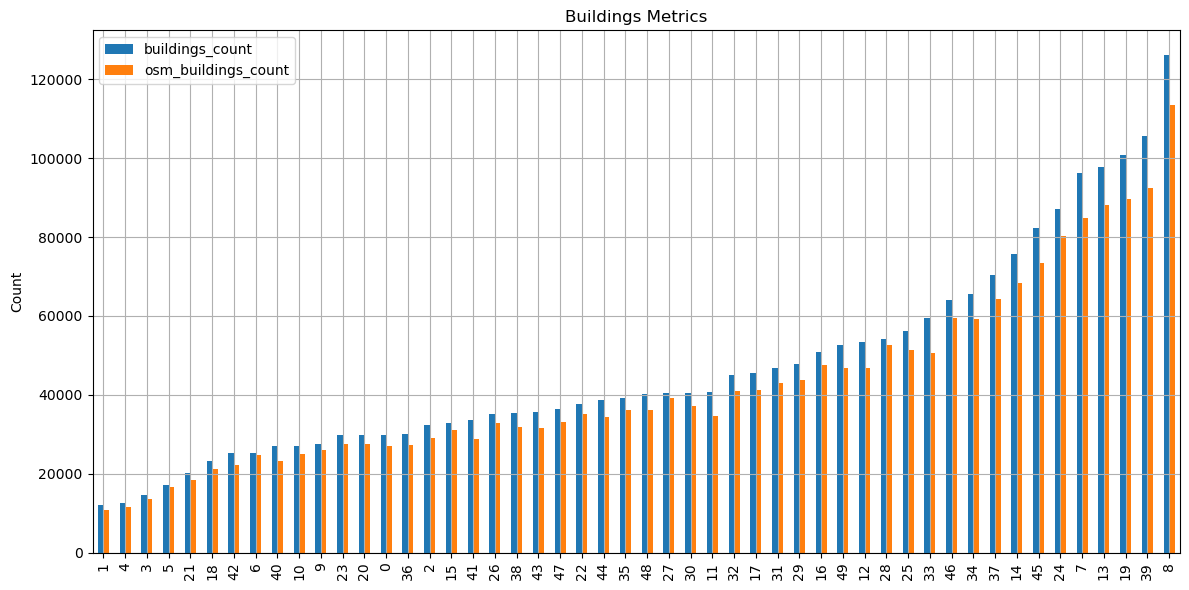

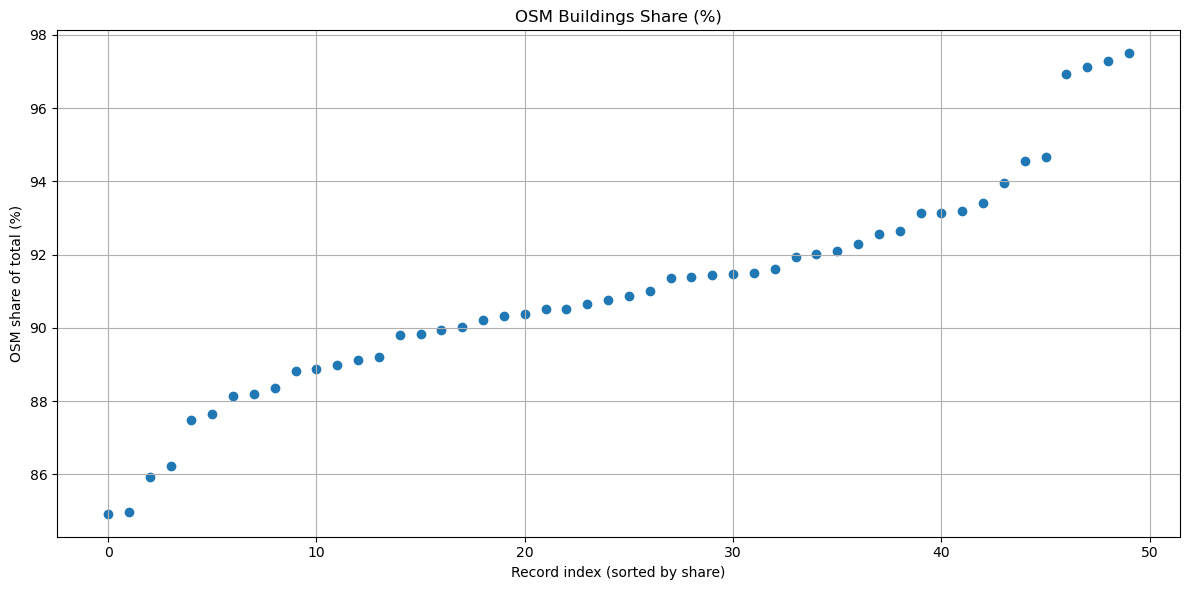

,buildings_count,osm_buildings_count
1,12130,10821
4,12492,11431
3,14507,13630
5,17029,16602
21,20136,18399
18,23296,21170
42,25110,22134
6,25343,24616
40,26930,23142
10,27002,24994


In [ ]:
analysis_df = pd.read_parquet(parquet_path)
if analysis_df.empty:
    raise RuntimeError('No data found in buildings_investigation_result.parquet.')

chart_df = analysis_df.sort_values('buildings_count')
ax = chart_df[['buildings_count', 'osm_buildings_count']].plot(
    kind='bar',
    figsize=(12, 6)
)
ax.set_title('Buildings Metrics')
ax.set_ylabel('Count')
ax.grid(True)
plt.tight_layout()
plt.show()

share_df = chart_df.copy()
denom = share_df['buildings_count'].replace(0, pd.NA)
share_df['osm_share_pct'] = (share_df['osm_buildings_count'] / denom) * 100
share_sorted = share_df.sort_values('osm_share_pct').reset_index(drop=True)
share_sorted['osm_share_pct'] = share_sorted['osm_share_pct'].astype(float)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(range(len(share_sorted)), share_sorted['osm_share_pct'])
ax.set_title('OSM Buildings Share (%)')
ax.set_xlabel('Record index (sorted by share)')
ax.set_ylabel('OSM share of total (%)')
ax.grid(True)
plt.tight_layout()
plt.show()
chart_df[[  'buildings_count', 'osm_buildings_count']].head(10)


In [ ]:
retriever.close()
